In [18]:
%load_ext autoreload
%autoreload 2
import copy
import gc
import sys

sys.path.append('..')

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from src.utils.cross_validation import TimeSeriesGroupSplit
from src.utils.downcasting import downcast_dtypes

sns.set(font_scale=1.2)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
random_state = 42

# Stacking

In this notebook we will produce predictions by stacking of LightGBM, Ridge.

## Preparing datasets

In [20]:
# for column date_block_num load original train
train_original = pd.read_feather('../data/processed/train.ftr')

train_lgb = pd.read_csv('../models/oof/lgb/train_selected.csv')
test_lgb = pd.read_csv('../models/oof/lgb/test_selected.csv')

train_ridge = pd.read_csv('../models/oof/ridge/train_selected.csv')
test_ridge = pd.read_csv('../models/oof/ridge/test_selected.csv')

In [21]:
train_ridge.drop(columns=['target'], inplace=True)

In [22]:
X_train = pd.concat((train_lgb, train_ridge), axis=1)
X_test = pd.concat((test_lgb, test_ridge), axis=1)
X_train.head()

,lgb,lgb_clipped,target,ridge,ridge_clipped
0,0.820543,0.820543,3.0,0.820556,0.820556
1,0.435353,0.435353,1.0,0.484089,0.484089
2,0.675429,0.675429,1.0,0.435195,0.435195
3,-0.000355,0.000000,1.0,0.419419,0.419419
4,0.397884,0.397884,2.0,0.788804,0.788804


In [23]:
train_size = train_lgb.shape[0]

X_train['date_block_num'] = train_original.iloc[-train_size:].date_block_num.values
X_test['date_block_num'] = X_train.date_block_num.max() + 1
del train_original
gc.collect();

### Removing target

In [24]:
y = X_train.target
X_train.drop(columns=['target'], inplace=True)

### Creation of validation split

In [25]:
y_valid = y[X_train.date_block_num == 33]
X_valid = X_train[X_train.date_block_num == 33]

y_train = y[X_train.date_block_num < 33]
X_train = X_train[X_train.date_block_num < 33]

## Hyperparameters tuning

In [26]:
ts = TimeSeriesGroupSplit(n_splits=5)

In [32]:
ridge_params = {
    'random_state': random_state
}

In [28]:
pipe_ridge = Pipeline(
    [('standartization', StandardScaler()),
     ('regression', Ridge(**ridge_params))]
)

default_score = cross_val_score(
    pipe_ridge, 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()
print(f'Current score: {-default_score:.5f}')

Current score: 0.97773


Score: $0.87776$.

Score after selection: $0.97773$.

In [33]:
pipe_ridge = Pipeline([('standartization', StandardScaler()), 
                       ('regression', Ridge(**ridge_params))])

param_grid = {
    'regression__alpha': np.logspace(4, 6, 10),
}

gs = GridSearchCV(
    pipe_ridge, 
    param_grid,          
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=10,
    refit=False,
    cv=ts
)

In [34]:
gs.fit(X_train, y_train, groups=X_train.date_block_num)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] regression__alpha=10000.0 .......................................
[CV] .......... regression__alpha=10000.0, score=-0.925, total=   1.0s
[CV] regression__alpha=10000.0 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] .......... regression__alpha=10000.0, score=-1.129, total=   1.8s
[CV] regression__alpha=10000.0 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s


[CV] .......... regression__alpha=10000.0, score=-0.987, total=   2.3s
[CV] regression__alpha=10000.0 .......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV] .......... regression__alpha=10000.0, score=-0.931, total=   2.9s
[CV] regression__alpha=10000.0 .......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.1s remaining:    0.0s


[CV] .......... regression__alpha=10000.0, score=-0.916, total=   3.5s
[CV] regression__alpha=16681.005372000593 ............................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   11.6s remaining:    0.0s


[CV]  regression__alpha=16681.005372000593, score=-0.925, total=   0.8s
[CV] regression__alpha=16681.005372000593 ............................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.4s remaining:    0.0s


[CV]  regression__alpha=16681.005372000593, score=-1.129, total=   1.6s
[CV] regression__alpha=16681.005372000593 ............................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.0s remaining:    0.0s


[CV]  regression__alpha=16681.005372000593, score=-0.986, total=   2.6s
[CV] regression__alpha=16681.005372000593 ............................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.6s remaining:    0.0s


[CV]  regression__alpha=16681.005372000593, score=-0.931, total=   3.7s
[CV] regression__alpha=16681.005372000593 ............................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   20.3s remaining:    0.0s


[CV]  regression__alpha=16681.005372000593, score=-0.916, total=   4.1s
[CV] regression__alpha=27825.59402207126 .............................
[CV]  regression__alpha=27825.59402207126, score=-0.925, total=   1.1s
[CV] regression__alpha=27825.59402207126 .............................
[CV]  regression__alpha=27825.59402207126, score=-1.129, total=   1.9s
[CV] regression__alpha=27825.59402207126 .............................
[CV]  regression__alpha=27825.59402207126, score=-0.985, total=   3.0s
[CV] regression__alpha=27825.59402207126 .............................
[CV]  regression__alpha=27825.59402207126, score=-0.931, total=   3.7s
[CV] regression__alpha=27825.59402207126 .............................
[CV]  regression__alpha=27825.59402207126, score=-0.916, total=   4.2s
[CV] regression__alpha=46415.88833612782 .............................
[CV]  regression__alpha=46415.88833612782, score=-0.925, total=   1.0s
[CV] regression__alpha=46415.88833612782 .............................
[CV] 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.2min finished


GridSearchCV(cv=TimeSeriesGroupSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('standartization', StandardScaler()),
                                       ('regression', Ridge(random_state=42))]),
             n_jobs=1,
             param_grid={'regression__alpha': array([  10000.        ,   16681.005372  ,   27825.59402207,
         46415.88833613,   77426.36826811,  129154.96650149,
        215443.46900319,  359381.36638046,  599484.25031894,
       1000000.        ])},
             refit=False, scoring='neg_root_mean_squared_error', verbose=10)

In [35]:
gs.best_params_

{'regression__alpha': 215443.46900318822}

In [36]:
ridge_params['alpha'] = 129155.0 # for all features
ridge_params['alpha'] = 215443.0 # for selected features

In [37]:
pipe_ridge = Pipeline([('standartization', StandardScaler()), 
                       ('regression', Ridge(**ridge_params))])

current_score = cross_val_score(
    pipe_ridge, 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()
print(f'Current score: {-current_score:.5f}')

Current score: 0.97697


Score: $0.87694$.

Score after selection: $0.97697$.

In [38]:
ridge_params

{'random_state': 42, 'alpha': 215443.0}

## Validation

In [39]:
model = Pipeline([('standartization', StandardScaler()), 
                  ('regression', Ridge(**ridge_params))])
model.fit(X_train, y_train)

Pipeline(steps=[('standartization', StandardScaler()),
                ('regression', Ridge(alpha=215443.0, random_state=42))])

In [40]:
y_predicted = np.clip(model.predict(X_valid), 0, 20)
validation_score = mean_squared_error(y_valid, y_predicted)
print(f'Validation score: {validation_score:.5f}')

Validation score: 1.06616


Score: $0.84454$

Score after selection: $1.06616$.

Let's look at predicted values charasteristics.

In [41]:
pd.Series(y_predicted).describe()

count    168139.000000
mean          0.344359
std           0.707794
min           0.000000
25%           0.088285
50%           0.160303
75%           0.346347
max          18.727692
dtype: float64

Let's look at feature importances.

In [42]:
ridge_coefs = model.named_steps['regression'].coef_
top_size = 10

sorted_indices = np.argsort(ridge_coefs)
sorted_names = X_train.columns[sorted_indices]

In [45]:
# plt.figure(figsize=(16, 9))
# sns.barplot(y=sorted_names[::-1], 
#             x=ridge_coefs[sorted_indices][::-1])
# plt.xlabel('Коэффициент перед признаком')
# plt.title(f'Значимости признаков для Ridge-регрессии')
# plt.savefig('../reports/figures/stacking/importances_selected_features.png', 
#             facecolor='white', bbox_inches='tight', pad_inches=0)
# plt.show()

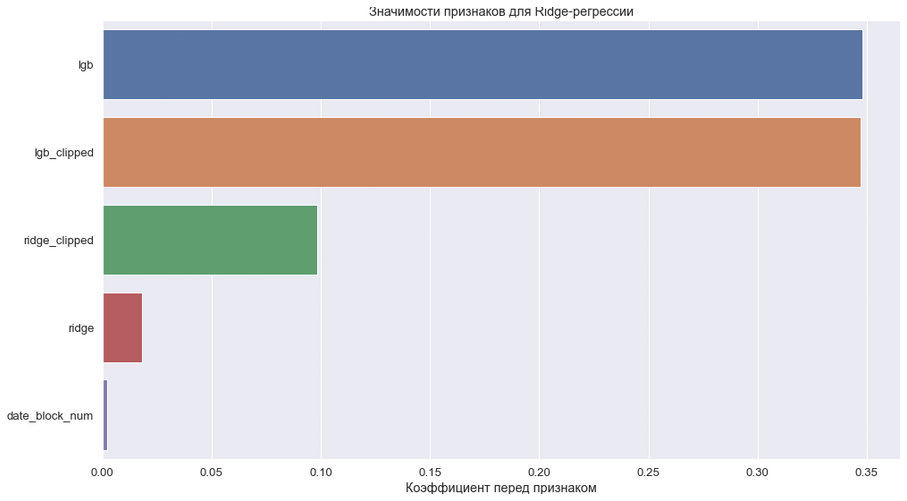

In [44]:
plt.figure(figsize=(16, 9))
image = plt.imread('../reports/figures/stacking/importances_selected_features.png')
plt.imshow(image, interpolation='spline36')
plt.axis('off')
plt.show()

## Submit

In this section we will train result model and submit prediction. Don't forget to clip values according to [evaluation tab](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation) (but ay be for tree-based methods it is not necessary).

In [46]:
X_train = pd.concat((X_train, X_valid))
y_train = pd.concat((y_train, y_valid))
gc.collect();

In [47]:
X_train.shape

(4704879, 5)

In [48]:
model = Pipeline([('standartization', StandardScaler()), 
                  ('regression', Ridge(**ridge_params))])
bags = 5

bagged_predictions = np.zeros(X_test.shape[0])
for n in tqdm(range(bags)):
    model.set_params(**{'regression__random_state': random_state+n})
    model.fit(X_train, y_train)
    bagged_predictions += np.clip(model.predict(X_test), 0, 20)
    gc.collect()
    
bagged_predictions /= bags

Create submission.

In [49]:
pd.Series(bagged_predictions).describe()

count    214200.000000
mean          0.324516
std           0.637858
min           0.000000
25%           0.088782
50%           0.161097
75%           0.330001
max          20.000000
dtype: float64

In [51]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission['item_cnt_month'] = bagged_predictions
submission.to_csv('../models/stacking/submission_selected.csv', index=False)

!kaggle competitions submit competitive-data-science-predict-future-sales -f ../models/ridge/submission.csv -m "Stacking of LightGBM, Ridge"

Result on all features: $0.99535$.

Result on selected features: $0.970271$.